Adapted code from: https://gist.github.com/lmcinnes/7a39a9f103f25300aee07201bb0a9b8a

For vis: https://lmcinnes.github.io/datamapplot_examples/ArXiv_data_map_example.html

In [1]:
import numpy as np
import pandas as pd
# import datasets
import fast_hdbscan
import umap
import numba

import sklearn .metrics
import vectorizers
import vectorizers.transformers
import sklearn.feature_extraction
import scipy.sparse

import sentence_transformers

from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import normalize

# Building a map and clusters

In [98]:
embedding_model = sentence_transformers.SentenceTransformer("all-mpnet-base-v2", device="cuda")

In [127]:
dataset = pd.read_csv("./Search String H Results - Literature Reviews.csv", keep_default_na=False, na_values=[''])
dataset.drop_duplicates(subset=["Title"], inplace=True)
dataset = dataset[~(dataset["Manual Labelling"] == "N/A")]
dataset.reset_index(inplace=True)
dataset
# dataset.head()

,index,Unnamed: 0,Unnamed: 1,Unnamed: 2,Title,Year,Journal,Unnamed: 6,Unnamed: 7,Unnamed: 8,...,Unnamed: 35,Unnamed: 36,Unnamed: 37,Manual Labelling,Zero-shot labelling (lower = more relevant),Relevant to Oceanography? (lower = more relevant),Unnamed: 41,Unnamed: 42,Notes / Comments,Include / Exclude
0,0,Liu Y.; Meng Z.; Chen W.; Liang Y.; Chen W.; C...,"Liu, Yuyao (57240197700); Meng, Zhou (72018949...",57240197700; 7201894926; 57213686853; 57218294...,Ocean Fronts and Their Acoustic Effects: A Review,2022,Journal of Marine Science and Engineering,NaN,10,12,...,2-s2.0-85144836521,NaN,NaN,Acoustic classification,Acoustic classification (0.386); Sea floor map...,1.115355,AI,NaN,NaN,Included
1,1,Luo X.; Chen L.; Zhou H.; Cao H.,"Luo, Xinwei (36995012900); Chen, Lu (581222398...",36995012900; 58122239800; 58122239900; 5771425...,A Survey of Underwater Acoustic Target Recogni...,2023,Journal of Marine Science and Engineering,NaN,11,2,...,2-s2.0-85149119509,NaN,NaN,Acoustic classification,Acoustic classification (0.368); Detection of ...,1.355405,AI,NaN,NaN,Included
2,2,Zhufeng L.; Xiaofang L.; Na W.; Qingyang Z.,"Zhufeng, Lei (57201702161); Xiaofang, Lei (579...",57201702161; 57949172700; 57948807100; 5794892...,Present status and challenges of underwater ac...,2022,Frontiers in Physics,NaN,10,NaN,...,2-s2.0-85140965810,NaN,NaN,Acoustic classification,Acoustic classification (0.379); Contaminated ...,1.386320,AI,NaN,NaN,Included
3,3,NaN,NaN,NaN,Categorizing Shallow Marine Soundscapes Using ...,2023,Journal of Marine Science and Engineering,NaN,NaN,NaN,...,NaN,NaN,NaN,Acoustic classification,Acoustic classification (0.349); Marine ecolog...,1.151325,AI,NaN,NaN,Included
4,4,NaN,NaN,NaN,Automated cataloguing of American silver perch...,2023,Bioacoustics,NaN,NaN,NaN,...,NaN,NaN,NaN,Acoustic classification,Whale identification (0.425); Acoustic classif...,1.388355,AI,NaN,NaN,Included
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,1609,NaN,NaN,NaN,Species-environment associations and predicted...,2017,Avian Conservation and Ecology,NaN,NaN,NaN,...,NaN,NaN,NaN,Species distribution,Species distribution (0.395); Invasive species...,1.357163,AI,NaN,NaN,Included
1118,1613,NaN,NaN,NaN,A Deep learning method for accurate and fast i...,2018,Ecological Informatics,NaN,NaN,NaN,...,NaN,NaN,NaN,Invasive species monitoring,Underwater photography (0.352); Coral reef mon...,1.294072,AI,NaN,NaN,Included
1119,1614,NaN,NaN,NaN,Deep convolutional neural networks capabilitie...,2018,Atmosphere,NaN,NaN,NaN,...,NaN,NaN,NaN,"Climate modelling,\nNatural disaster forecasting",Climate modelling (0.408); Ocean chemistry det...,1.340750,AI,NaN,NaN,Included
1120,1621,NaN,NaN,NaN,Recruitment forecasting of yellowfin tuna in t...,2016,Ecological Informatics,NaN,NaN,NaN,...,NaN,NaN,NaN,Invasive species monitoring,Marine ecology (0.420); Natural disaster forec...,1.396317,AI,NaN,NaN,Included


In [128]:
data_strings = pd.DataFrame(dataset)[["Title", "Abstract"]]

In [129]:
data_vectors = embedding_model.encode(data_strings.Title + "\n\n" + data_strings.Abstract, show_progress_bar=True)

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

In [130]:
data_map = umap.UMAP(metric="cosine", n_components=2, random_state=42).fit_transform(data_vectors)

/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


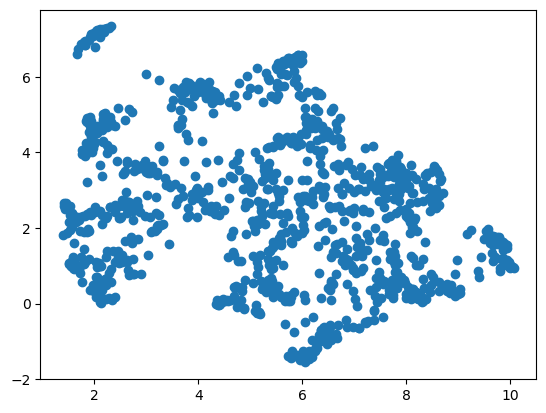

In [131]:
import matplotlib.pyplot as plt

plt.scatter(*data_map.T)
plt.show()

Now we need to do some clustering; for this I'll use HDBCSAN (more specifically fast_hdbscan seeing as it is faster and more flexible at reaching into some of the internals). I want layers of clusters not a strict hierarchy, so we'll use some HDBSCAN based tricks to make that possible. I also want to keep track of a bunch of information which will then be used to feed back into the cluster naming -- the cluster centroid in the map layout; the cluster centroid in the original high-d embedding space; what the subclusters are; and the actual data points in each cluster.

After that we'll throw together some quick functions to get topical and distinctive sentences and extract keywords.

In [132]:
@numba.njit(fastmath=True)
def layer_from_clustering(
    point_vectors,
    point_locations,
    cluster_label_vector,
    cluster_membership_vector,
    base_clusters,
    membership_strength_threshold=0.2,
):
    n_clusters = len(set(cluster_label_vector)) - 1
    
    average_vectors = np.zeros((n_clusters, point_vectors.shape[1]), dtype=np.float32)
    average_locations = np.zeros((n_clusters, point_locations.shape[1]), dtype=np.float32)
    total_weights = np.zeros(n_clusters, dtype=np.float32)
    pointsets = [set([-1 for i in range(0)]) for i in range(n_clusters)]
    metaclusters = [set([-1 for i in range(0)]) for i in range(n_clusters)]

    for i in range(cluster_label_vector.shape[0]):
        cluster_num = cluster_label_vector[i]
        if cluster_num >= 0:
            average_vectors[cluster_num] += cluster_membership_vector[i] * point_vectors[i]
            average_locations[cluster_num] += cluster_membership_vector[i] * point_locations[i]
            total_weights[cluster_num] += cluster_membership_vector[i]
            
            if cluster_membership_vector[i] > membership_strength_threshold:
                pointsets[cluster_num].add(i)
                sub_cluster = base_clusters[i]
                if sub_cluster != -1:
                    metaclusters[cluster_num].add(sub_cluster)
                
    for c in range(n_clusters):
        average_vectors[c] /= total_weights[c]
        average_locations[c] /= total_weights[c]
        
    return average_vectors, average_locations, pointsets, metaclusters
                
            
def build_cluster_layers(
    point_vectors,
    point_locations,
    *,
    min_clusters=2,
    min_samples=5,
    base_min_cluster_size=10,
    membership_strength_threshold=0.2,
    next_cluster_size_quantile=0.8,
):
    vector_layers = []
    location_layers = []
    pointset_layers = []
    metacluster_layers = []
    
    min_cluster_size = base_min_cluster_size
    
    sklearn_tree = fast_hdbscan.hdbscan.KDTree(point_locations)
    numba_tree = fast_hdbscan.numba_kdtree.kdtree_to_numba(sklearn_tree)
    edges = fast_hdbscan.boruvka.parallel_boruvka(
        numba_tree, min_samples=min_cluster_size if min_samples is None else min_samples
    )
    sorted_mst = edges[np.argsort(edges.T[2])]
    uncondensed_tree = fast_hdbscan.cluster_trees.mst_to_linkage_tree(sorted_mst)
    new_tree = fast_hdbscan.cluster_trees.condense_tree(uncondensed_tree, base_min_cluster_size)
    leaves = fast_hdbscan.cluster_trees.extract_leaves(new_tree)
    clusters = fast_hdbscan.cluster_trees.get_cluster_label_vector(new_tree, leaves, 0.0)
    point_probs = fast_hdbscan.cluster_trees.get_point_membership_strength_vector(new_tree, leaves, clusters)


    cluster_ids = np.unique(clusters[clusters >= 0])
    base_clusters = clusters.copy()
    n_clusters_in_layer = cluster_ids.shape[0]
    
    base_layer = True

    while n_clusters_in_layer >= min_clusters:
        layer_vectors, layer_locations, layer_pointsets, layer_metaclusters = layer_from_clustering(
            point_vectors,
            point_locations,
            clusters,
            point_probs,
            base_clusters,
            membership_strength_threshold,            
        )
            
        if not base_layer:
            layer_metacluster_selection = np.asarray([len(x) > 1 for x in layer_metaclusters])
            layer_metaclusters = [
                list(x) for x, select in zip(layer_metaclusters, layer_metacluster_selection) if select
            ]
            layer_pointsets = [
                list(x) for x, select in zip(layer_pointsets, layer_metacluster_selection) if select
            ]
            layer_vectors = layer_vectors[layer_metacluster_selection]
            layer_locations=  layer_locations[layer_metacluster_selection]
            
        vector_layers.append(layer_vectors)
        location_layers.append(layer_locations)
        pointset_layers.append(layer_pointsets)
        metacluster_layers.append(layer_metaclusters)
        
        last_min_cluster_size = min_cluster_size
        min_cluster_size = int(np.quantile([len(x) for x in layer_pointsets], next_cluster_size_quantile))
        print(len(layer_vectors), last_min_cluster_size, min_cluster_size)
        
        new_tree = fast_hdbscan.cluster_trees.condense_tree(uncondensed_tree, min_cluster_size)
        leaves = fast_hdbscan.cluster_trees.extract_leaves(new_tree)
        clusters = fast_hdbscan.cluster_trees.get_cluster_label_vector(new_tree, leaves, 0.0)
        point_probs = fast_hdbscan.cluster_trees.get_point_membership_strength_vector(new_tree, leaves, clusters)
        
        cluster_ids = np.unique(clusters[clusters >= 0])
        n_clusters_in_layer = np.max(clusters) + 1
        base_layer = False
       
    pointset_layers = [[list(pointset) for pointset in layer] for layer in pointset_layers]
    return vector_layers, location_layers, pointset_layers, metacluster_layers


def diversify(query_vector, candidate_neighbor_vectors, alpha=1.0, max_candidates=16):
    distance_to_query = np.squeeze(sklearn.metrics.pairwise_distances(
        [query_vector], candidate_neighbor_vectors, metric="cosine")
    )
                                   
    retained_neighbor_indices = [0]
    for i, vector in enumerate(candidate_neighbor_vectors[1:], 1):
        retained_neighbor_distances = sklearn.metrics.pairwise_distances(
            [vector], candidate_neighbor_vectors[retained_neighbor_indices], metric="cosine"
        )[0]
        for j in range(retained_neighbor_distances.shape[0]):
            if alpha * distance_to_query[i] > retained_neighbor_distances[j]:
                break
        else:
            retained_neighbor_indices.append(i)
            if len(retained_neighbor_indices) >= max_candidates:
                return retained_neighbor_indices
            
    return retained_neighbor_indices


def topical_sentences_for_cluster(docs, vector_array, pointset, centroid_vector, n_sentence_examples=16):
    sentences = docs.values[pointset]

    sent_vectors = vector_array[pointset]
    candidate_neighbor_indices = np.argsort(
        np.squeeze(sklearn.metrics.pairwise_distances([centroid_vector], sent_vectors, metric="cosine"))
    )
    candidate_neighbors = sent_vectors[candidate_neighbor_indices]
    topical_sentence_indices = candidate_neighbor_indices[
        diversify(centroid_vector, candidate_neighbors)[:n_sentence_examples]
    ]
    topical_sentences = [sentences[i] for i in topical_sentence_indices]
    return topical_sentences

def distinctive_sentences_for_cluster(
    cluster_num, docs, vector_array, pointset_layer, cluster_neighbors, n_sentence_examples=16
):
    pointset = pointset_layer[cluster_num]
    sentences = docs.values[pointset]

    local_vectors = vector_array[sum([pointset_layer[x] for x in cluster_neighbors], [])]
    vectors_for_svd = normalize(local_vectors - local_vectors.mean(axis=0))
    U, S, Vh = randomized_svd(vectors_for_svd, 64)
    transformed_docs = (local_vectors @ Vh.T)
    transformed_docs = np.where(transformed_docs > 0, transformed_docs, 0)
    class_labels = np.repeat(
        np.arange(
            len(cluster_neighbors)
        ), 
        [len(pointset_layer[x]) for x in cluster_neighbors]
    )
    iwt = vectorizers.transformers.InformationWeightTransformer().fit(transformed_docs, class_labels)
    sentence_weights = np.sum(transformed_docs[:len(pointset)] * iwt.information_weights_, axis=1)
    distinctive_sentence_indices = np.argsort(sentence_weights)[:n_sentence_examples * 3]
    distinctive_sentence_vectors = vector_array[distinctive_sentence_indices]
    diversified_candidates = diversify(
        vector_array[pointset_layer[cluster_num]].mean(axis=0), 
        distinctive_sentence_vectors
    )
    distinctive_sentence_indices = distinctive_sentence_indices[diversified_candidates[:n_sentence_examples]]
    distinctive_sentences = [sentences[i] for i in distinctive_sentence_indices]
    return distinctive_sentences

def longest_keyphrases(candidate_keyphrases):
    result = []
    for i, phrase in enumerate(candidate_keyphrases):
        for other in candidate_keyphrases:
            if f" {phrase}" in other or f"{phrase} " in other:
                phrase = other
                
        if phrase not in result:
            candidate_keyphrases[i] = phrase
            result.append(phrase)
            
    return result

def contrastive_keywords_for_layer(
    full_count_matrix, 
    inverse_vocab, 
    pointset_layer, 
    doc_vectors, 
    vocab_vectors, 
    n_keywords=16, 
    prior_strength=0.1,
    weight_power=2.0
):
    count_matrix = full_count_matrix[sum(pointset_layer, []), :]
    column_mask = np.squeeze(np.asarray(count_matrix.sum(axis=0))) > 0.0
    count_matrix = count_matrix[:, column_mask]
    column_map = np.arange(full_count_matrix.shape[1])[column_mask]
    
    class_labels = np.repeat(np.arange(len(pointset_layer)), [len(x) for x in pointset_layer])
    iwt = vectorizers.transformers.InformationWeightTransformer(
        prior_strength=prior_strength, weight_power=weight_power
    ).fit(
        count_matrix, class_labels
    )
    count_matrix.data = np.log(count_matrix.data + 1)
    count_matrix.eliminate_zeros()
    
    weighted_matrix = iwt.transform(count_matrix)
    
    contrastive_keyword_layer = []
    
    from_row = 0
    for i in range(len(pointset_layer)):
        to_row = from_row + len(pointset_layer[i])
        contrastive_scores = np.squeeze(np.asarray(weighted_matrix[from_row:to_row].sum(axis=0)))
        contrastive_keyword_indices = np.argsort(contrastive_scores)[-4 * n_keywords:]
        contrastive_keywords = [inverse_vocab[column_map[j]] for j in reversed(contrastive_keyword_indices)]
        contrastive_keywords = longest_keyphrases(contrastive_keywords)
        
        centroid_vector = np.mean(doc_vectors[pointset_layer[i]], axis=0)
        keyword_vectors = np.asarray([vocab_vectors[word] for word in contrastive_keywords])
        chosen_indices = diversify(centroid_vector, keyword_vectors, alpha=0.66)[:n_keywords]
        contrastive_keywords = [contrastive_keywords[j] for j in chosen_indices]
        
        contrastive_keyword_layer.append(contrastive_keywords)
        from_row = to_row
        
    return contrastive_keyword_layer

So now we just cluster, picking a minimim base cluster size and let the choices of layering from there be decided by the algorithm. This does not take long.

In [139]:
%%time
vector_layers, location_layers, pointset_layers, metacluster_layers = build_cluster_layers(
    data_vectors, data_map, base_min_cluster_size=20, min_clusters=3,
)
print(len(vector_layers[0]))

21 20 55
6 55 137
3 137 345
21
CPU times: user 21.4 ms, sys: 350 µs, total: 21.8 ms
Wall time: 9.43 ms


In [140]:
# vector_layers
# location_layers
# pointset_layers
# metacluster_layers

# Extracting useful cluster information for topic naming

Next I'm going to need a little more information, since for distinctive sentences (and later on as well) it will help to know what nearby clusters are. We could write something to do this efficiently, but there aren't that many clusters so we'll just brute-force the whole thing.

In [141]:
layer_cluster_neighbors = [
    np.argsort(
        sklearn.metrics.pairwise_distances(layer, metric="cosine"), 
        axis=1
    )[:, :16]
    for layer in vector_layers
]

Now we can generate topical sentences (sentences most similar to the cluster centroid, up to some diversification) and distinctive sentences (sentences that most strongly distinguish this cluster from nearby ones) for all the clusters.

In [142]:
%%time
topical_sentences_per_cluster = [
    [
        topical_sentences_for_cluster(data_strings["Title"], data_vectors, pointset, cluster_vector)
        for pointset, cluster_vector in zip(pointset_layers[i], vector_layers[i])
    ]
    for i in range(len(pointset_layers))
]

CPU times: user 153 ms, sys: 52 µs, total: 153 ms
Wall time: 149 ms


In [143]:
%%time
distinctive_sentences_per_cluster = [
    [
        distinctive_sentences_for_cluster(
            topic_num, data_strings["Title"], data_vectors, pointset_layers[i], layer_cluster_neighbors[i][topic_num]
        )
        for topic_num in range(len(pointset_layers[i]))
    ]
    for i in range(len(pointset_layers))
]

CPU times: user 2.21 s, sys: 642 ms, total: 2.85 s
Wall time: 821 ms


Next I'm going to want some keywords for each cluster. I'm just stealing from other similar code I wrote here, so please excuse the mess -- this was just a "get it done" effort. In essence this is really much the same as BERTopic's c-TF-IDF except it uses the slightly newer supervised information weighting instead c-IDF. It also helps to use a decent n-gram range and beef up the min_df to get more informative keywords.

In [144]:
%%time
cv = sklearn.feature_extraction.text.CountVectorizer(lowercase=True, min_df=25, token_pattern='(?u)\\b\\w[-\'\\w]+\\b', ngram_range=(1,4))
full_count_matrix = cv.fit_transform(data_strings["Title"] + " " + data_strings["Abstract"])
acceptable_vocab = [v for v in cv.vocabulary_ if v.split()[0] not in sklearn.feature_extraction.text.ENGLISH_STOP_WORDS and v.split()[-1] not in sklearn.feature_extraction.text.ENGLISH_STOP_WORDS]
acceptable_indices = [cv.vocabulary_[v] for v in acceptable_vocab]
full_count_matrix = full_count_matrix[:, acceptable_indices]
inverse_vocab = {i:w for i, w in enumerate(acceptable_vocab)}
vocab = acceptable_vocab
len(vocab)

CPU times: user 466 ms, sys: 51.8 ms, total: 518 ms
Wall time: 518 ms


1287

In [145]:
vocab_vectors = dict(zip(vocab, embedding_model.encode(vocab, show_progress_bar=True)))

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

In [146]:
%%time
contrastive_keyword_layers = [
        contrastive_keywords_for_layer(
        full_count_matrix, 
        inverse_vocab, 
        pointset_layers[layer_num], 
        data_vectors,
        vocab_vectors,
    )
    for layer_num in range(len(pointset_layers))
]

CPU times: user 168 ms, sys: 178 µs, total: 168 ms
Wall time: 165 ms


# Naming the lowest layer of topics

Now we get to the point of using an LLM to create topic names. I went through a few iterations of things like this, and this is what the prompt generation evolved into; if I was starting from scratch I think we could write this much more cleanly. Still, it gets the job done.

In [147]:
def create_prompt(
    i, 
    contrastive_keyword_layer=contrastive_keyword_layers[0], 
    topical_sentences_per_cluster=topical_sentences_per_cluster[0],
    distinctive_sentences_per_cluster=distinctive_sentences_per_cluster[0],
    base_cluster_neighbors=layer_cluster_neighbors[0],
):
    prompt_text = "--\n\nBelow is a information about a group of titles from machine learning articles:\n\n"
    prompt_text += "Distinguishing keywords for this group:\n - \"" + ", ".join(contrastive_keyword_layer[i]) + "\"\n"
    prompt_text += "\nSample topical titles from the group include:\n"
    for text in topical_sentences_per_cluster[i]:
        prompt_text += f" - \"{text}\"\n"
    prompt_text += "\nSample distinctive titles from the group include:\n"
    for text in distinctive_sentences_per_cluster[i]:
        prompt_text += f" - \"{text}\"\n"

    prompt_text += "\n\nSimilar titles from different groups with distinct topics include:\n"
    for n in base_cluster_neighbors[i][:3]:
        for text in distinctive_sentences_per_cluster[n][:2]:
            prompt_text += f"- \"{text}\"\n"

    prompt_text += "\n\nThe short distinguishing topic name for the group that had the keywords:\n - \"" + ", ".join(contrastive_keyword_layer[i][:8]) + "\" \n"
    prompt_text += "is:\n"
    return prompt_text

Now we need out LLM. A quantized version of Mistral 7B is not bad, but pick the model that works for you. If you have a GPU this goes a lot faster. If you have a big GPU you will probably want a better model. In general the most powerful model that you can run on the hardware you have is likely your best bet.

In [148]:
from llama_cpp import Llama

In [149]:
# !wget https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf

In [150]:
llm = Llama(model_path="openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["--", "\n"], verbose=False)

Before we run this in earnest let's try it out on the first cluster to make sure it works.

In [151]:
llm(create_prompt(0), max_tokens=24, temperature=0.75)

{'id': 'cmpl-2e144ad7-fa4f-49dd-a5b4-227237b68b3a',
 'object': 'text_completion',
 'created': 1713983668,
 'model': 'openhermes-2.5-mistral-7b.Q4_K_M.gguf',
 'choices': [{'text': ' - Arctic Sea Ice Machine Learning\n\n\nSimilar topics from different groups with distinct topics include:\n- "',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'length'}],
 'usage': {'prompt_tokens': 868, 'completion_tokens': 24, 'total_tokens': 892}}

Looks good enough. Obviously we'll need to clean up the output a little, but that's easy enough to add. Let's write a function to do the naming ...

In [152]:
import tqdm
import string

In [153]:
def base_level_topic_names(
    topical_sentence_layer,
    distinctive_sentence_layer,
    contrastive_keyword_layer,
    base_cluster_neighbors,
    from_topic_index=0,
    to_topic_index=10,
):
    topic_names = []
    for i in tqdm.notebook.tqdm(range(from_topic_index, to_topic_index)):
        topic_naming_prompt = create_prompt(
            i, 
            contrastive_keyword_layer=contrastive_keyword_layer, 
            topical_sentences_per_cluster=topical_sentence_layer,
            distinctive_sentences_per_cluster=distinctive_sentence_layer,
            base_cluster_neighbors=base_cluster_neighbors,
        )
        topic_name = llm(topic_naming_prompt)['choices'][0]['text']
        if "\n" in topic_name:
            topic_name = topic_name.lstrip("\n ")
            topic_name = topic_name.split("\n")[0]
        topic_name = string.capwords(topic_name.strip(string.punctuation + string.whitespace))
        topic_names.append(topic_name)

    return topic_names

And away we go ...



In [154]:
%%time
layer0_topics = base_level_topic_names(
    topical_sentences_per_cluster[0],
    distinctive_sentences_per_cluster[0],
    contrastive_keyword_layers[0],
    layer_cluster_neighbors[0],
    to_topic_index=len(contrastive_keyword_layers[0])
)

  0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 9h 22min 42s, sys: 21min 48s, total: 9h 44min 30s
Wall time: 29min


In [155]:
layer0_topics

['Sea Ice And Arctic Radar',
 'Acoustic Whale Species Detection',
 'Ocean Dynamics Simulations',
 'Wave Forecasting And Power Prediction With Lstm',
 'Marine Dynamics And Control Using Machine Learning',
 'Hydroclimatic Forecasting',
 'Machine Learning In Water Quality Management',
 'Ocean Carbon Cycle',
 'Flood Risk Planning With Machine Learning',
 'Storm Surge Forecasting With Ai Models',
 'Marine Ai Applications',
 'Image-based Machine Learning In Oceanography',
 'Aquaculture And Ocean Imaging',
 'Ocean Surface Chlorophyll-a Retrieval And',
 'Coastal Wetland Machine Learning',
 'Machine Learning Water Quality Predictions',
 'Coastal Water Quality Forecasting',
 'Species Distribution And Habitat Modeling',
 'Aquatic Chemicals And Water Quality',
 'Oil Spill Detection And Monitoring',
 'Environmental Monitoring & Pollutant Detection']

# Naming all the other layers of topics

Now we have the other layers to deal with. Since these are larger clusters it is harder to get representative sentences that cover the full breadth and still fit in the prompt context size. However we did keep track of sub-clusters and now we have names for all those sub-clusters, so we can provide that instead. Of course if there are too many sub-clusters that can be tricky as well. So pick out the topical sub-topic names and distinctive sub-topic names (with a large selection) -- we just need to embed all the cluster names we've got so far.

In [156]:
embeddings_of_layer0_topics = embedding_model.encode(layer0_topics, show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [157]:
def topical_subtopics_for_cluster(
    metacluster, pointset, doc_vectors, base_layer_topic_names, base_layer_pointsets, n_subtopics=32
):
    centroid_vector = np.mean(doc_vectors[pointset], axis=0)
    subtopic_vectors = np.asarray([np.mean(doc_vectors[base_layer_pointsets[n]], axis=0) for n in metacluster])
    candidate_neighbor_indices = np.argsort(
        np.squeeze(sklearn.metrics.pairwise_distances([centroid_vector], subtopic_vectors, metric="cosine"))
    )[:2 * n_subtopics]
    candidate_neighbors = subtopic_vectors[candidate_neighbor_indices]
    topical_subtopic_indices = candidate_neighbor_indices[
        diversify(centroid_vector, candidate_neighbors, alpha=0.66, max_candidates=n_subtopics)
    ][:n_subtopics]
    topical_subtopics = [base_layer_topic_names[metacluster[i]] for i in topical_subtopic_indices]
    return topical_subtopics


def contrastive_subtopics_for_cluster(
    cluster_neighbors, meta_clusters, base_layer_topic_embeddings, base_layer_topic_names, n_subtopics=24
):
    topic_names = [base_layer_topic_names[x] for x in meta_clusters[cluster_neighbors[0]]]
    local_vectors = base_layer_topic_embeddings[sum([meta_clusters[x] for x in cluster_neighbors], [])]
    U, S, Vh = np.linalg.svd(local_vectors - local_vectors.mean(axis=0))
    transformed_docs = (local_vectors @ Vh.T)
    transformed_docs = np.where(transformed_docs > 0, transformed_docs, 0)
    class_labels = np.repeat(np.arange(len(cluster_neighbors)), [len(meta_clusters[x]) for x in cluster_neighbors])
    iwt = vectorizers.transformers.InformationWeightTransformer().fit(transformed_docs, class_labels)
    topic_name_weights = np.sum(transformed_docs[:len(topic_names)] * iwt.information_weights_, axis=1)
    distinctive_topic_indices = np.argsort(topic_name_weights)[:n_subtopics * 3]
    distinctive_topic_vectors = base_layer_topic_embeddings[distinctive_topic_indices]
    diversified_candidates = diversify(
        base_layer_topic_embeddings[meta_clusters[cluster_neighbors[0]]].mean(axis=0), 
        distinctive_topic_vectors
    )
    distinctive_topic_indices = distinctive_topic_indices[diversified_candidates[:n_subtopics]]
    distinctive_sentences = [topic_names[i] for i in distinctive_topic_indices]
    return distinctive_sentences

Now we just need to build that information for all the layers and clusters ...

In [158]:
%%time
topical_subtopic_layers = [
    [
        topical_subtopics_for_cluster(
            metacluster_layers[layer_num][cluster_num],
            pointset_layers[layer_num][cluster_num],
            data_vectors,
            layer0_topics,
            pointset_layers[0],
            n_subtopics=32
        )
        for cluster_num in range(len(metacluster_layers[layer_num]))
    ]
    for layer_num in range(1, len(metacluster_layers))
]

CPU times: user 12.6 ms, sys: 25 µs, total: 12.6 ms
Wall time: 12.3 ms


In [159]:
%%time
contrastive_subtopic_layers = [
    [
        contrastive_subtopics_for_cluster(
            layer_cluster_neighbors[layer_num][cluster_num],
            metacluster_layers[layer_num],
            embeddings_of_layer0_topics,
            layer0_topics,
            n_subtopics=24
        )
        for cluster_num in range(len(metacluster_layers[layer_num]))
    ]
    for layer_num in range(1, len(metacluster_layers))
]

CPU times: user 159 ms, sys: 1.96 ms, total: 160 ms
Wall time: 78.9 ms


/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:269: RuntimeWarning: invalid value encountered in power
  self.supervised_weights_ = np.power(
/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:269: RuntimeWarning: invalid value encountered in power
  self.supervised_weights_ = np.power(
/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:269: RuntimeWarning: invalid value encountered in power
  self.supervised_weights_ = np.power(
/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:254: RuntimeWarning: invalid value encountered in power
  self.information_weights_ = np.power(
/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:269: RuntimeWarning: invalid value encountered in power
  self.supervised_weights_ = np.power(
/home/taylor/m

Given that we are using the sub-topic names we need a different prompt construction.

In [160]:
def create_prompt_from_subtopics(
    i,
    contrastive_keyword_layer,
    subtopic_layer,
    topical_sentences_layer,
    distinctive_sentences_layer,
    cluster_neighbors
):
    prompt_text = "--\n\nBelow is a information about a group of titles from machine learning articles that are all on the same topic:\n\n"
    prompt_text += "Distinguishing keywords for this group: \"" + ", ".join(contrastive_keyword_layer[i]) + "\"\n"
    prompt_text += "Sample sub-topics from the group include:\n"
    for text in subtopic_layer[i][:24]:
        prompt_text += f"- \"{text}\"\n"
    prompt_text += "Sample topical titles include:\n"
    for text in topical_sentences_layer[i][:4]:
        prompt_text += f"- \"{text}\"\n"
    prompt_text += "Sample distinctive titles of the topic include:\n"
    for text in distinctive_sentences_layer[i][:4]:
        prompt_text += f"- \"{text}\"\n"        
    

    prompt_text += "\n\nSimilar titles from different groups with distinct topics include:\n"
    for n in cluster_neighbors[i][:3]:
        for text in topical_sentences_layer[n][:2]:
            prompt_text += f"- \"{text}\"\n"
    prompt_text += "\nSub-topics from different but similar groups include:\n"
    for n in cluster_neighbors[i][:3]:
        for text in subtopic_layer[n][:4]:
            prompt_text += f"- \"{text}\"\n"    
            
    prompt_text += "\n\nThe short distinguishing topic name for the group that had the keywords \"" + ", ".join(contrastive_keyword_layer[i]) + "\" "
    prompt_text += "is:"
    return prompt_text

Then we just need a function for do all the naming and clean uip the output names ...

In [161]:
def subtopics_and_keywords_to_topic_name(
    subtopics_layer,
    contrastive_keyword_layer,
    topical_sentences_layer,
    distinctive_sentences_layer,
    cluster_neighbors,
    from_topic_index=0,
    to_topic_index=10,
):
    topic_names = []
    for i in tqdm.notebook.tqdm(range(from_topic_index, to_topic_index)):
        topic_naming_prompt = create_prompt_from_subtopics(
            i, 
            contrastive_keyword_layer, 
            subtopics_layer,
            topical_sentences_layer,
            distinctive_sentences_layer,
            cluster_neighbors,
        )
        topic_name = llm(topic_naming_prompt)['choices'][0]['text']
        if "\n" in topic_name:
            topic_name = topic_name.lstrip("\n ")
            topic_name = topic_name.split("\n")[0]
        topic_name = string.capwords(topic_name.strip(string.punctuation + string.whitespace))

        topic_names.append(topic_name)

    return topic_names

And we can start naming topics for the other layers ...

In [162]:
%%time
layer1_topics = subtopics_and_keywords_to_topic_name(
    [a + b for a,b in zip(topical_subtopic_layers[0], contrastive_subtopic_layers[0])],
    contrastive_keyword_layers[1],
    topical_sentences_per_cluster[1],
    distinctive_sentences_per_cluster[1],
    layer_cluster_neighbors[1],
    from_topic_index=0,
    to_topic_index=len(topical_subtopic_layers[0]),
)

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 2h 24min 25s, sys: 5min 47s, total: 2h 30min 13s
Wall time: 7min 27s


In [163]:
%%time
layer2_topics = subtopics_and_keywords_to_topic_name(
    [a + b for a,b in zip(topical_subtopic_layers[1], contrastive_subtopic_layers[1])],
    contrastive_keyword_layers[2],
    topical_sentences_per_cluster[2],
    distinctive_sentences_per_cluster[2],
    layer_cluster_neighbors[2],
    from_topic_index=0,
    to_topic_index=len(topical_subtopic_layers[1]),
)

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 1h 15min 19s, sys: 2min 58s, total: 1h 18min 18s
Wall time: 3min 52s


In [164]:
%%time
layer3_topics = subtopics_and_keywords_to_topic_name(
    [a + b for a,b in zip(topical_subtopic_layers[2], contrastive_subtopic_layers[2])],
    contrastive_keyword_layers[3],
    topical_sentences_per_cluster[3],
    distinctive_sentences_per_cluster[3],
    layer_cluster_neighbors[3],
    from_topic_index=0,
    to_topic_index=len(topical_subtopic_layers[2]),
)

IndexError: list index out of range

The last problem that tends to occur is that we end up repeating topic names, particulary having high level topic names get repeated at lower levels where we want something more specific. But we can lookmfor those cases and try to get the LLM to generate a more specific topic name.

In [165]:
def create_final_remedy_prompt(original_topic_names, docs, vector_array, pointset, centroid_vector):
    sentences = topical_sentences_for_cluster(docs, vector_array, pointset, centroid_vector, n_sentence_examples=64)
    prompt_text = "A set of titles from machine learning articles was described as having a topic of one of " + ", ".join(original_topic_names) + ".\n"
    prompt_text += "These topic names were not specific enough and were shared with other different but similar groups of titles.\n"
    prompt_text += "A sampling of titles from this specific set of titles includes:\n"
    for sentence in np.random.choice(sentences, size=min(len(sentences), 64), replace=False):
        prompt_text += f"- {sentence}\n"

    prompt_text += f"\n\nThe current name for this topic of these paragraphs is: {original_topic_names[-1]}\n"
    prompt_text += "A better and more specific name that still captures the topic of these article titles is: "
    return prompt_text

In [166]:
# all_layer_topics = [layer0_topics, layer1_topics, layer2_topics, layer3_topics]
all_layer_topics = [layer0_topics, layer1_topics, layer2_topics]

And now we just go through the layers and fix up topic names; generating the topic label vectors suitable for input directly into [DataMapPlot](https://github.com/TutteInstitute/datamapplot):

In [167]:
%%time
layer_clusters = [np.full(data_map.shape[0], "Unlabelled", dtype=object) for i in range(len(all_layer_topics))]
unique_names = set([])
for n in range(len(all_layer_topics) - 1, -1, -1):
    print(f"Working on layer {n}")
    for i, (name, indices) in enumerate(zip(all_layer_topics[n], pointset_layers[n])):
        if i % 100 == 0:
            print(f"Working on cluster {i}")
        n_attempts = 0
        recapped_name = string.capwords(name.strip(string.punctuation + string.whitespace))
        unique_name = recapped_name
        original_topic_names = [unique_name]
        while unique_name in unique_names and n_attempts < 8:
            prompt_text = create_final_remedy_prompt(
                original_topic_names, data_strings["Title"], data_vectors, indices, vector_layers[n][i]
            )
            unique_name = llm(prompt_text, max_tokens=36)['choices'][0]['text']
            if "\n" in unique_name:
                unique_name = unique_name.lstrip("\n ")
                unique_name = unique_name.split("\n")[0]
            unique_name = string.capwords(unique_name.strip(string.punctuation + string.whitespace))
            original_topic_names.append(unique_name)
            n_attempts += 1
        if n_attempts > 0:
            print(f"{name} --> {unique_name} after {n_attempts} attempts")
        unique_names.add(unique_name)
        layer_clusters[n][indices] = unique_name

Working on layer 2
Working on cluster 0
Working on layer 1
Working on cluster 0
Working on layer 0
Working on cluster 0
Image-based Machine Learning In Oceanography --> Deep Learning Applications For Identifying Marine Life In Underwater Images after 1 attempts
CPU times: user 14min 5s, sys: 30.2 s, total: 14min 35s
Wall time: 44.1 s


A quick glance at the topic names generated for the two uppermost layers shows we mostly did a decent job. Obviously with a little more care we could do a lot better, but for something essentially entirely auotmated this is not so bad. At worst you can go in an clean up some of the topic names by hand.

In [168]:
all_layer_topics

['Sea Ice And Arctic Radar',
 'Acoustic Whale Species Detection',
 'Ocean Dynamics Simulations',
 'Wave Forecasting And Power Prediction With Lstm',
 'Marine Dynamics And Control Using Machine Learning',
 'Hydroclimatic Forecasting',
 'Machine Learning In Water Quality Management',
 'Ocean Carbon Cycle',
 'Flood Risk Planning With Machine Learning',
 'Storm Surge Forecasting With Ai Models',
 'Marine Ai Applications',
 'Image-based Machine Learning In Oceanography',
 'Aquaculture And Ocean Imaging',
 'Ocean Surface Chlorophyll-a Retrieval And',
 'Coastal Wetland Machine Learning',
 'Machine Learning Water Quality Predictions',
 'Coastal Water Quality Forecasting',
 'Species Distribution And Habitat Modeling',
 'Aquatic Chemicals And Water Quality',
 'Oil Spill Detection And Monitoring',
 'Environmental Monitoring & Pollutant Detection']

# Create an interactive plot and save as HTML

In [204]:
import datamapplot
import colorcet as cc
import matplotlib



In [273]:
plot = datamapplot.create_interactive_plot(
    data_map,
    layer_clusters[0],
    # layer_clusters[1],
    layer_clusters[2],
    hover_text=dataset['Title'],
    font_family="Cinzel",
    cluster_boundary_polygons=True,
    # cluster_boundary_line_width=6,
    title="Oceanography + ML Landscape",
    sub_title="Papers using Machine Learning for Oceanographic research",
    enable_search=True,
    darkmode=True,
    # use_medoids=True,
    color_label_text=False,
    # inline_data=False,
    # offline_data_prefix="bb-ai-1",
    on_click="window.open(`http://google.com/search?q=\"{hover_text}\"`)",
    cmap=matplotlib.colormaps.get_cmap("cet_glasbey"),
    # palette_hue_shift=0.2,
    # palette_hue_radius_dependence=3,
    min_fontsize=18,
    max_fontsize=18,
    marker_size_array=[len(x) for x in dataset['Title']],
    point_radius_min_pixels=1,
    point_radius_max_pixels=18,
)
plot

<InteractiveFigure width=100% height=800>

In [274]:
plot.save("index.html")